# OpenET SSEBop
## Image Class Property/Method Example
This example shows how to instantiate the model Image class for a single Landsat image using the ".from_landsat_c1_toa()" helper method.  This example also shows how to get the model variables.

## Setup

### Install Earth Engine

In [1]:
# Import the Earth Engine package, installing it first, if needed.
try:
    import ee
except ModuleNotFoundError:
    !pip install earthengine-api
    import ee

### Install SSEBop

In [2]:
# Import the SSEBop package, installing it first, if needed.
try:
    import openet.ssebop as model
except ModuleNotFoundError:
    !pip install openet-ssebop
    import openet.ssebop as model

gridded C version


### Package Imports

In [3]:
import pprint

from IPython.display import Image

### Initialize Earth Engine

In [4]:
# Initialize the Earth Engine package, initiating the authentication flow if needed.
try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize()

## Analysis

In [5]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']

image_size = 768

### Landsat 8 Collection 1 TOA Image

In [6]:
# Nevada image
# landsat_id = 'LANDSAT/LC08/C01/T1_TOA/LC08_041032_20170711'
# landsat_img = ee.Image(landsat_id)
# pprint.pprint(landsat_img.getInfo())
# # pprint.pprint(landsat_img.geometry().bounds(1, 'EPSG:32611').getInfo())
# clip_geom = ee.Geometry.Rectangle([510000, 4440000, 560000, 4470000], 'EPSG:32611', False)
# # clip_geom = ee.Geometry.Rectangle([450000, 4400000, 650000, 4500000], 'EPSG:32611', False)
# clip_region = clip_geom.bounds(1, 'EPSG:32611').getInfo()

# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_042035_20150713')
# clip_geom = ee.Geometry.Rectangle([750000, 3900000, 850000, 4000000], 'EPSG:32610', False)
# clip_region = clip_geom.bounds(1, 'EPSG:32610').getInfo()

landsat_img = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044033_20170716')
# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_044033_20170801')
# Fields
# clip_geom = ee.Geometry.Rectangle([600000, 4270000, 625000, 4285000], 'EPSG:32610', False)
# Lake
# clip_geom = ee.Geometry.Rectangle([560000, 4260000, 575000, 4285000], 'EPSG:32610', False)
# clip_geom = ee.Geometry.Rectangle([560000, 4260000, 625000, 4290000], 'EPSG:32610', False)
clip_geom = ee.Geometry.Rectangle([550000, 4250000, 640000, 4300000], 'EPSG:32610', False)
clip_region = clip_geom.bounds(1, 'EPSG:32610').getInfo()

landsat_crs = landsat_img.select('B3').projection().getInfo()['crs']
landsat_dt = ee.Date(landsat_img.get('system:time_start'))
# print(landsat_img.get('system:time_start').getInfo())

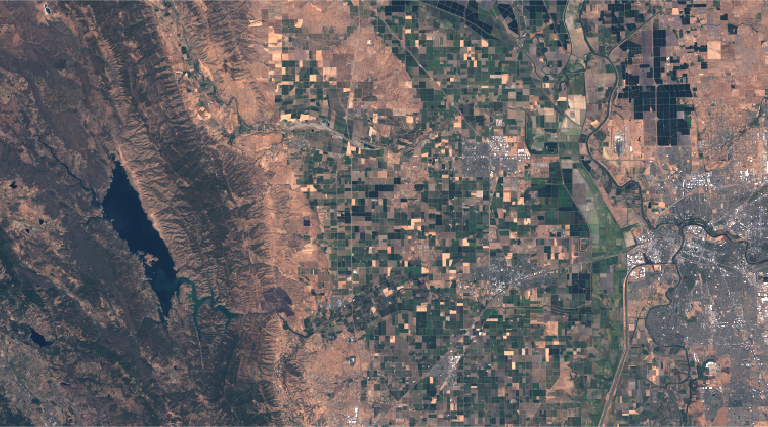

In [8]:
image_url = landsat_img.select([3, 2, 1]).clip(clip_geom)\
    .getThumbURL({'min': 0.0, 'max': 0.3, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [9]:
# Build the SSEBop object from the Landsat image
model_obj = model.Image.from_landsat_c1_toa(
    landsat_img.clip(clip_geom), 
    tcorr_source='GRIDDED',
    # et_reference_source='projects/climate-engine/cimis/daily', 
    # et_reference_band='ETr_ASCE',
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='etr', 
    et_reference_factor=0.85,
    et_reference_resample='nearest',
)

### NDVI

In [11]:
# image_url = model_obj.ndvi\
#     .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
#                   'region': clip_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

### Tcorr

In [12]:
pprint.pprint(model_obj.tcorr.getInfo())

{'bands': [{'crs': 'EPSG:32610',
            'crs_transform': [5000, 0, 15, 0, -5000, 15],
            'data_type': {'precision': 'double', 'type': 'PixelType'},
            'id': 'tcorr'}],
 'properties': {'image_id': 'LANDSAT/LC08/C01/T1_TOA/LC08_044033_20170716',
                'system:index': 'LC08_044033_20170716',
                'system:time_start': 1500230731093,
                'tcorr_coarse_count_cold': 121,
                'tcorr_index': 0},
 'type': 'Image'}


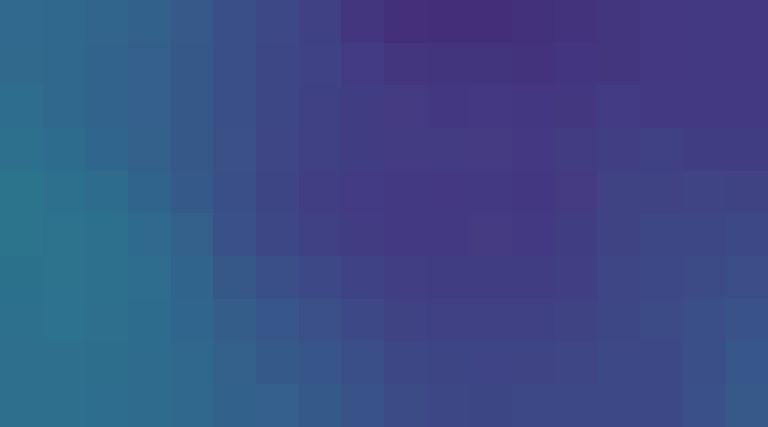

In [13]:
# image_url = ee.Image(model_obj.tcorr_gridded).select(['tcorr'])\
image_url = model_obj.tcorr\
    .getThumbURL({'min': 0.97, 'max': 1.1, 'palette': viridis_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Tcorr "Quality"

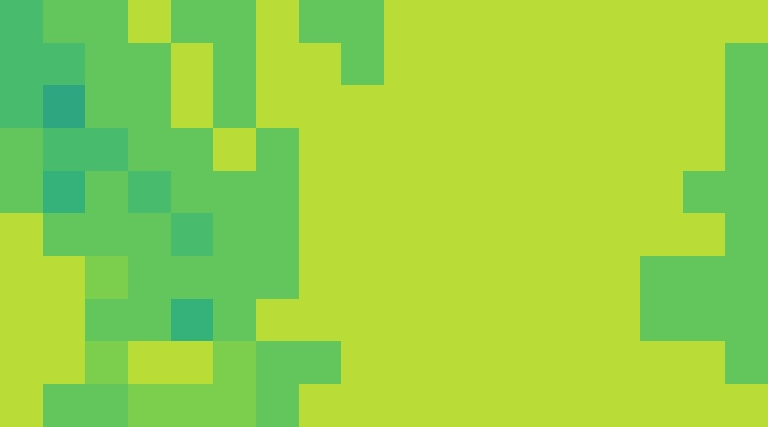

In [20]:
image_url = ee.Image(model_obj.tcorr_gridded).select(['quality'])\
    .getThumbURL({'min': 0, 'max': 20, 'palette': viridis_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET fraction

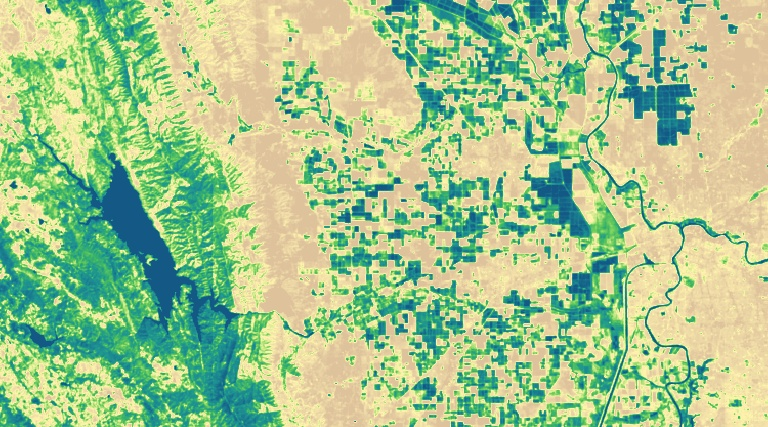

In [14]:
image_url = model_obj.et_fraction\
    .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Reference ET

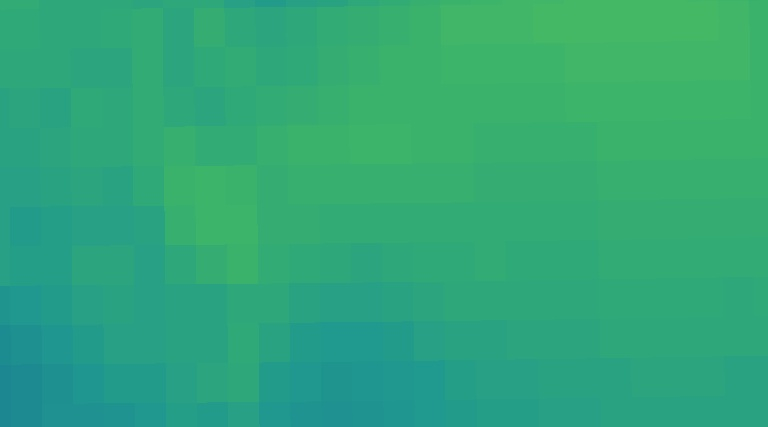

In [23]:
# Clip and project to the Landsat image footprint and coordinate system
image_url = model_obj.et_reference\
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET

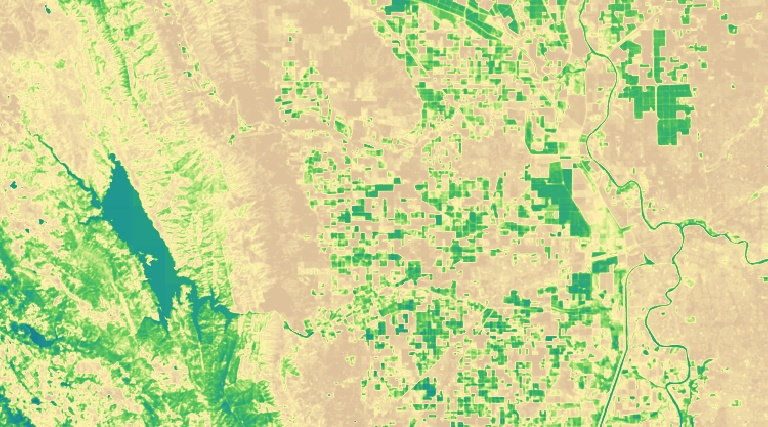

In [24]:
image_url = model_obj.et\
    .getThumbURL({'min': 0.0, 'max': 15, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### "Calculate" Method

Return a multiband image of the model variables

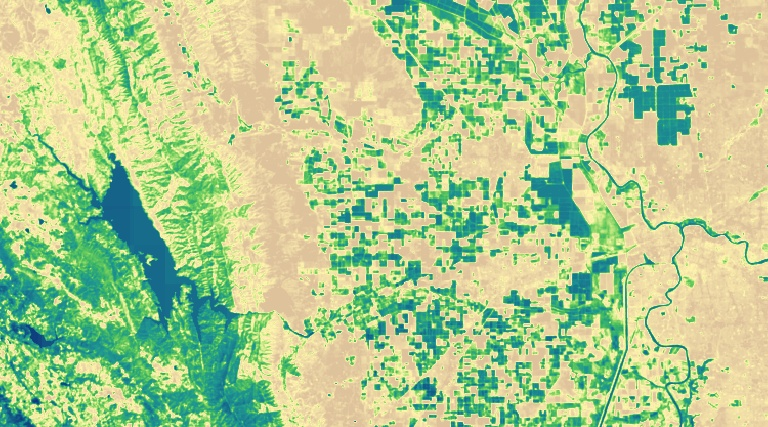

In [25]:
image_url = model_obj.calculate(['et', 'et_reference', 'et_fraction']).select(['et'])\
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Precomputed Gridded Tcorr

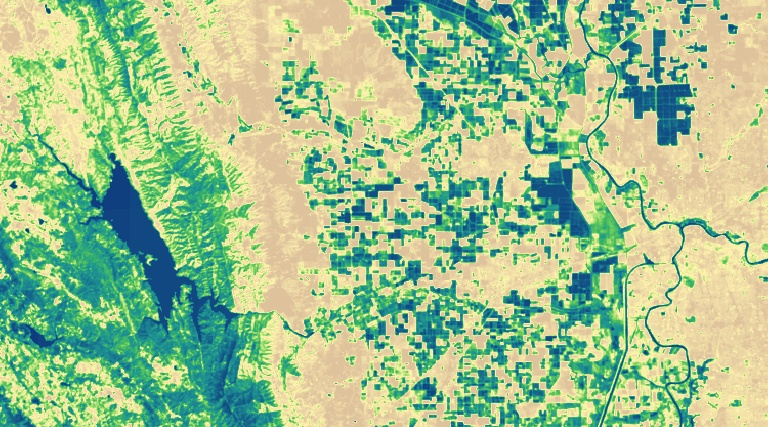

In [22]:
model_obj = model.Image.from_landsat_c1_toa(
    landsat_img.clip(clip_geom), 
    tcorr_source='SCENE_GRIDDED',
    # et_reference_source='projects/climate-engine/cimis/daily', 
    # et_reference_band='ETr_ASCE',
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='eto', 
    et_reference_factor=0.85,
    et_reference_resample='nearest',
    et_fraction_type='grass',
)
image_url = model_obj.et_fraction\
    .getThumbURL({'min': 0.0, 'max': 1.4, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')